In [1]:
try:
    import qiskit_nature
except:
    %pip install qiskit-nature[pyscf] -U
    import qiskit_nature
    
qiskit_nature.__version__

'0.7.2'

In [2]:
from qiskit_nature.second_q.drivers import PySCFDriver

driver = PySCFDriver(
    atom="""C      1.1291      0.0795     -0.5259
  C      0.7115     -1.2207     -0.4748
  H      2.0789      0.4171     -0.9381
  H      1.2719     -2.0822     -0.8377
  S     -0.0500      1.1306      0.1514
  N     -1.1147     -0.1822      0.5074
  C     -0.5926     -1.3347      0.1299
  H     -1.1422     -2.2662      0.2851""", #Coordonnées xyz de la molecule 1,2-Thiazole atom
    basis='STO-3G', # Ensemble de base
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)
# Obtenir l'Electronic structure problem
problem = driver.run()

In [3]:
# For 3D plotting
try :
    import py3Dmol
except:
    %pip install py3Dmol
    import py3Dmol
py3Dmol.__version__

'2.1.0'

In [4]:
"""_3D representation with py3Dmol
"""
# Create a py3Dmol.view object
xyz_view = py3Dmol.view(width=300, height=300)

# Add the molecule model to the view
xyz_view.addModel(driver._mol.build().tostring(format="xyz"),'xyz')

# Set the style of representation
xyz_view.setStyle({'stick': {}, 'sphere': {'scale': 0.30}})

# Zoom to fit the molecule in the view
xyz_view.zoomTo()

# Show the molecule view
xyz_view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

* Extraction de quelques propriétés

In [5]:
print(f"Molecule, basis: {driver.basis}, Hartree-Fock calculation")
print(f"Number of alpha electrons: {problem.num_alpha}")
print(f"Number of beta electrons: {problem.num_beta}")
print(f"Number of spin orbitals: {problem.num_spin_orbitals}")
print(f"Spin orbitals occupation: {problem.orbital_occupations}")
print(f"Spin orbitals energies: {problem.orbital_energies}")
print(f"Molecule reference (HF) total energy: {problem.reference_energy} Ha")
print(f"Molecule nuclear repulsion energy: {problem.nuclear_repulsion_energy} Ha")


Molecule, basis: STO-3G, Hartree-Fock calculation
Number of alpha electrons: 22
Number of beta electrons: 22
Number of spin orbitals: 64
Spin orbitals occupation: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
Spin orbitals energies: [-90.84544727 -15.32141747 -11.06407434 -11.04110113 -11.02753474
  -8.73707496  -6.36878764  -6.36729122  -6.3646857   -1.19448958
  -0.98941296  -0.92735272  -0.72288664  -0.69941879  -0.63361482
  -0.51551986  -0.48793488  -0.48191303  -0.40782084  -0.34186567
  -0.30009975  -0.27940707   0.23917557   0.37822271   0.38660052
   0.50039675   0.61283911   0.69130018   0.76619362   0.824971
   0.90816777   1.04637883]
Molecule reference (HF) total energy: -560.8391624792076 Ha
Molecule nuclear repulsion energy: 203.5391249740159 Ha


In [6]:
# Fermi Level and properties
print(f"HOMO and LUMO indexes are {problem.num_alpha-1, problem.num_alpha}")
print(f"HOMO and LUMO energies are {problem.orbital_energies[problem.num_alpha-1],problem.orbital_energies[problem.num_alpha]}")
print(f"HOMO-LUMO gap is {abs(problem.orbital_energies[problem.num_alpha-1]-problem.orbital_energies[problem.num_alpha])}")

HOMO and LUMO indexes are (21, 22)
HOMO and LUMO energies are (-0.2794070652303577, 0.23917557014184046)
HOMO-LUMO gap is 0.5185826353721982


* Hamiltonien fermionique

In [7]:
hamiltonian = problem.hamiltonian # Hamiltonien en 1ere quantification
fermionic_op = hamiltonian.second_q_op() # Hamiltonien fermionique
if len(fermionic_op) <= 20:
    print(fermionic_op)
else: # print the first 20 terms of the fermionic Hamiltonian operator of the molecule
    print("\n".join(str(fermionic_op).splitlines()[:22] + ["..."]))

Fermionic Operator
number spin orbitals=64, number terms=3684300
  -133.51097155013863 * ( +_0 -_0 )
+ 0.0006518955429942256 * ( +_0 -_1 )
+ 3.143923288033004e-05 * ( +_0 -_2 )
+ 0.0003590764959097779 * ( +_0 -_3 )
+ 8.276538092982827e-06 * ( +_0 -_4 )
+ 2.05643434357229 * ( +_0 -_5 )
+ 0.005492885107597892 * ( +_0 -_6 )
+ 0.08004838450215104 * ( +_0 -_7 )
+ -8.042500051163865e-07 * ( +_0 -_8 )
+ -0.16826237800184332 * ( +_0 -_9 )
+ -0.10458188908529739 * ( +_0 -_10 )
+ -0.30561193216812627 * ( +_0 -_11 )
+ -0.22595484990822548 * ( +_0 -_12 )
+ -0.06324853439302525 * ( +_0 -_13 )
+ -0.08231816849526698 * ( +_0 -_14 )
+ 0.018875174714329698 * ( +_0 -_15 )
+ 0.05731060628178545 * ( +_0 -_16 )
+ 6.967527942363253e-05 * ( +_0 -_17 )
+ -0.18100710830210295 * ( +_0 -_18 )
+ -0.012208666668346333 * ( +_0 -_19 )
...


In [8]:
problem.num_particles

(22, 22)

* Définition d'un espace actif autour du niveau de Fermi

Nous allons choisir un espace actif avec 4 orbitale spatiale, c'est-à-dire HOMO-1, HOMO, LUMO, LUMO+1.

In [21]:
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
problem = ActiveSpaceTransformer(4, 4).transform(problem)

problem.num_particles

(2, 2)

In [11]:
hamiltonian = problem.hamiltonian # Hamiltonien en 1ere quantification
fermionic_op = hamiltonian.second_q_op() # Hamiltonien fermionique
if len(fermionic_op) <= 20:
    print(fermionic_op)
else: # print the first 20 terms of the fermionic Hamiltonian operator of the molecule
    print("\n".join(str(fermionic_op).splitlines()[:22] + ["..."]))

Fermionic Operator
number spin orbitals=8, number terms=1056
  -1.2387577587819418 * ( +_0 -_0 )
+ 0.0020177772442738417 * ( +_0 -_1 )
+ 0.00028970618112898056 * ( +_0 -_2 )
+ 0.028729479455168228 * ( +_0 -_3 )
+ 0.002017777244275729 * ( +_1 -_0 )
+ -1.2199029720042969 * ( +_1 -_1 )
+ -0.01408856699499058 * ( +_1 -_2 )
+ -0.015825236367074263 * ( +_1 -_3 )
+ 0.0002897061811240956 * ( +_2 -_0 )
+ -0.014088566994988415 * ( +_2 -_1 )
+ -0.9562180614543099 * ( +_2 -_2 )
+ 0.0004059115415063243 * ( +_2 -_3 )
+ 0.028729479455170005 * ( +_3 -_0 )
+ -0.015825236367075595 * ( +_3 -_1 )
+ 0.00040591154150760103 * ( +_3 -_2 )
+ -0.8229460404402207 * ( +_3 -_3 )
+ -1.2387577587819436 * ( +_4 -_4 )
+ 0.0020177772442738417 * ( +_4 -_5 )
+ 0.00028970618112898056 * ( +_4 -_6 )
+ 0.028729479455168228 * ( +_4 -_7 )
...


* Hamiltonien qubit avec la réduction $\mathbb{Z}_2$

In [12]:
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper, BravyiKitaevMapper, TaperedQubitMapper

mapper = ParityMapper(num_particles=problem.num_particles)
mapper = problem.get_tapered_mapper(mapper)
Hamil_z2qubit = mapper.map(fermionic_op)

print(f"Number of items in the PM Z2 Pauli list:", len(Hamil_z2qubit))
if len(Hamil_z2qubit) <= 10:
    print(Hamil_z2qubit)
else:
    print(Hamil_z2qubit[0:10])

* Circuit de l'état initial

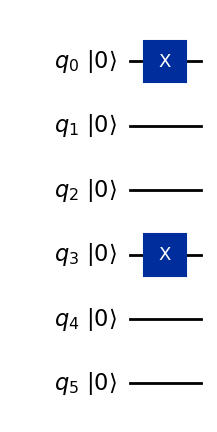

In [14]:
from qiskit_nature.second_q.circuit.library import HartreeFock

hf_state = HartreeFock(problem.num_spatial_orbitals, problem.num_particles, mapper)
hf_state.draw('mpl',initial_state=True)